In [1]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import spatialproteomics as sp
import xarray as xr
import pandas as pd
import tifffile
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score, f1_score
from statsmodels.stats.inter_rater import fleiss_kappa

import matplotlib as mpl

mpl.style.core.use('/g/huber/users/meyerben/notebooks/spatialproteomics_pipelines/spatialproteomics_bnhl/figures/pub_matplotlib_rc.ini')
font_size = 6.5
point_size = 20
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

# --- Global style ---
mpl.rcParams.update({
    "font.size": font_size,        # for labels, ticks, legends
    "axes.labelsize": font_size,   # axis labels
    "xtick.labelsize": font_size,  # x tick labels
    "ytick.labelsize": font_size,  # y tick labels
    "legend.fontsize": font_size,  # legend text
    "lines.linewidth": line_width, # default line width
    "axes.linewidth": line_width,  # axes border width
    "grid.linewidth": line_width   # grid lines
})

# Initialize dictionaries
ct_marker_dict = {'PAX5': 'B cell', 'CD3': 'T cell', 'CD11b': 'Myeloid cell',
                  'CD11c': 'Dendritic cell', 'CD68': 'Macrophage',
                  'CD90': 'Stromal cell', 'Podoplanin': 'Stromal cell',
                  'CD31': 'Endothelial cell', 'CD34': 'Endothelial cell'}

astir_dict = {'cell_type': {'B cell': ['PAX5'], 
                            'T cell': ['CD3'], 
                            'Myeloid cell': ['CD11b'],
                            'Dendritic cell': ['CD11c'],
                            'Macrophage': ['CD68'],
                            'Stromal cell': ['CD90', 'Podoplanin'],
                            'Endothelial cell': ['CD31', 'CD34']}}

celltype_colors = {
    'B cell': '#5799d1',
    'T cell': '#ebc850',
    'Myeloid cell': '#de6866',
    'Dendritic cell': '#4cbcbd',
    'Macrophage': '#bb7cb4',
    'Stromal cell': '#62b346',
    'Endothelial cell': '#bf997d'
}
marker_colors = {
    'PAX5': '#5799d1',
    'CD3': '#ebc850',
    'CD11b': '#de6866',
    'CD11c': '#4cbcbd',
    'CD68': '#bb7cb4',
    'CD90': '#62b346',
    'Podoplanin': '#62b346',
    'CD31': '#bf997d',
    'CD34': '#bf997d',
}

df = pd.read_csv('label_df.csv', index_col=0)

# Drop the sample column if present
labels_df = df.drop(columns=["Sample"], errors="ignore")

# Cohen's Kappa

In [2]:
def pairwise_metrics(labels1, labels2):
    kappa = cohen_kappa_score(labels1, labels2)
    return kappa

label_sets = labels_df.columns

kappa_matrix = pd.DataFrame(index=label_sets, columns=label_sets, dtype=float)

for a, b in combinations(label_sets, 2):
    kappa = pairwise_metrics(labels_df[a], labels_df[b])
    kappa_matrix.loc[a, b] = kappa
    kappa_matrix.loc[b, a] = kappa

# Fill diagonals
np.fill_diagonal(kappa_matrix.values, 1.0)

/tmp/ipykernel_10961/3648682661.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


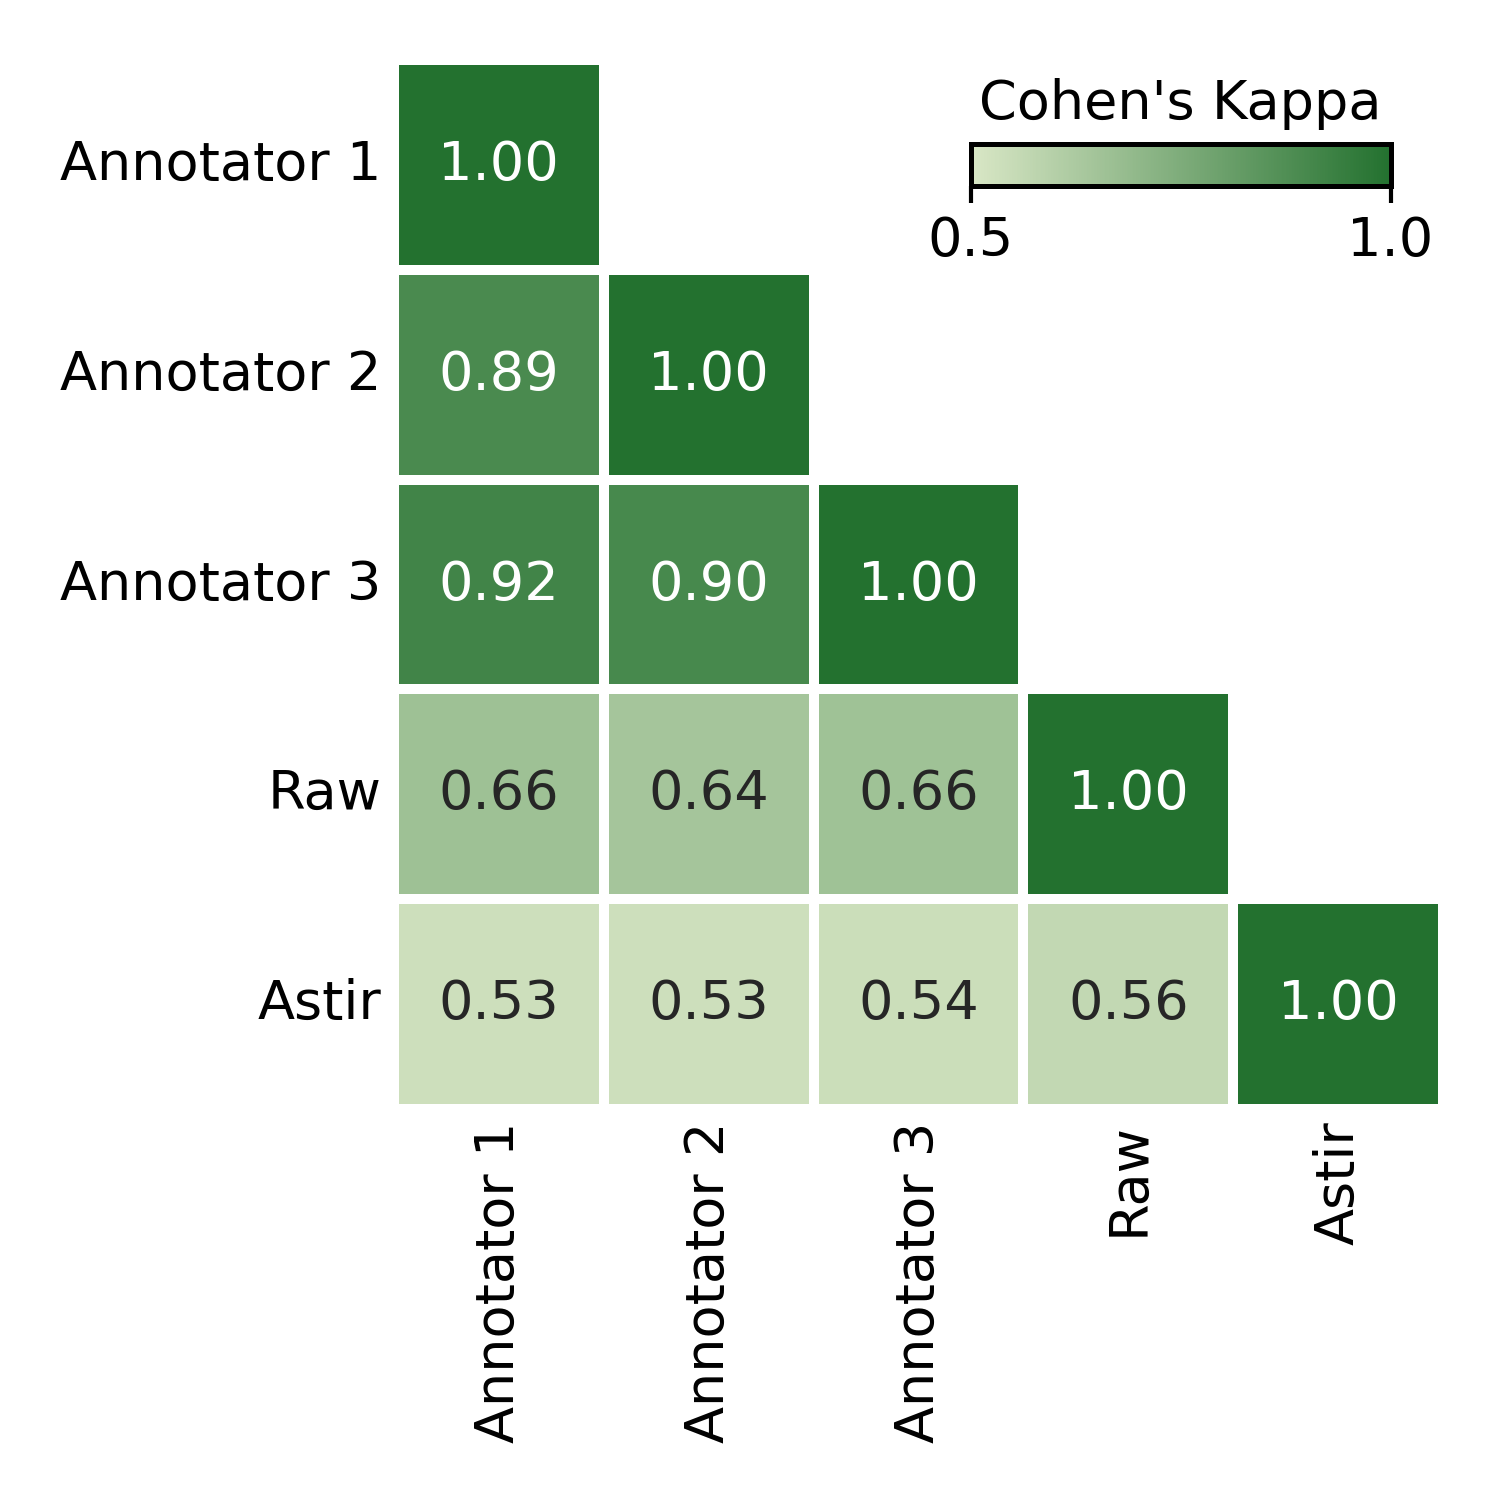

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Example colormap
bottom_color = "#d9e7c6"
top_color = "#23712f"
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [bottom_color, top_color])
norm = mcolors.Normalize(vmin=0.5, vmax=1)

# Mask strictly above diagonal (keep diagonal)
mask = np.triu(np.ones_like(kappa_matrix, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=600)

sns.heatmap(
    kappa_matrix.astype(float),
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=1,
    linecolor='white',
    cmap=cmap,
    norm=norm,
    mask=mask,
    cbar=False  # turn off default colorbar
)

# Customize x and y ticks
custom_labels = ["Annotator 1", "Annotator 2", "Annotator 3", "Raw", "Astir"]
ax.set_xticks(np.arange(len(custom_labels)) + 0.5)
ax.set_xticklabels(custom_labels, rotation=90, ha="center")
ax.set_yticks(np.arange(len(custom_labels)) + 0.5)
ax.set_yticklabels(custom_labels, rotation=0)

# Hide tick marks
ax.tick_params(axis='both', length=0)

# --- Add horizontal colorbar inside plot ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cax = inset_axes(
    ax,
    width="40%",       # width of the colorbar relative to ax
    height="4%",       # height of the colorbar
    loc="upper left",
    bbox_to_anchor=(0.55, -0.08, 1, 1),  # tweak this to lower it slightly
    bbox_transform=ax.transAxes,
    borderpad=0
)

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=[0.5, 1])
cbar.set_label("Cohen's Kappa", fontsize=font_size, labelpad=3)
cbar.ax.xaxis.set_label_position("top")  # move label above
cbar.ax.tick_params(labelsize=font_size, length=2)

plt.tight_layout()
plt.savefig('figures/thresholding_panel_a.png', bbox_inches='tight', pad_inches=0) #, format='svg')
plt.show()

# Pairwise confusion matrix

In [4]:
# Compute confusion matrices
labels = sorted(set(labels_df["Matthias"]) | set(labels_df["Nora"]) | set(labels_df["Nicklas"]))

cm_nora = confusion_matrix(labels_df["Matthias"], labels_df["Nora"], labels=labels)
cm_nicklas = confusion_matrix(labels_df["Matthias"], labels_df["Nicklas"], labels=labels)

# Normalize row-wise (optional, easier to compare)
cm_nora = cm_nora.astype(float) / cm_nora.sum(axis=1, keepdims=True)
cm_nicklas = cm_nicklas.astype(float) / cm_nicklas.sum(axis=1, keepdims=True)

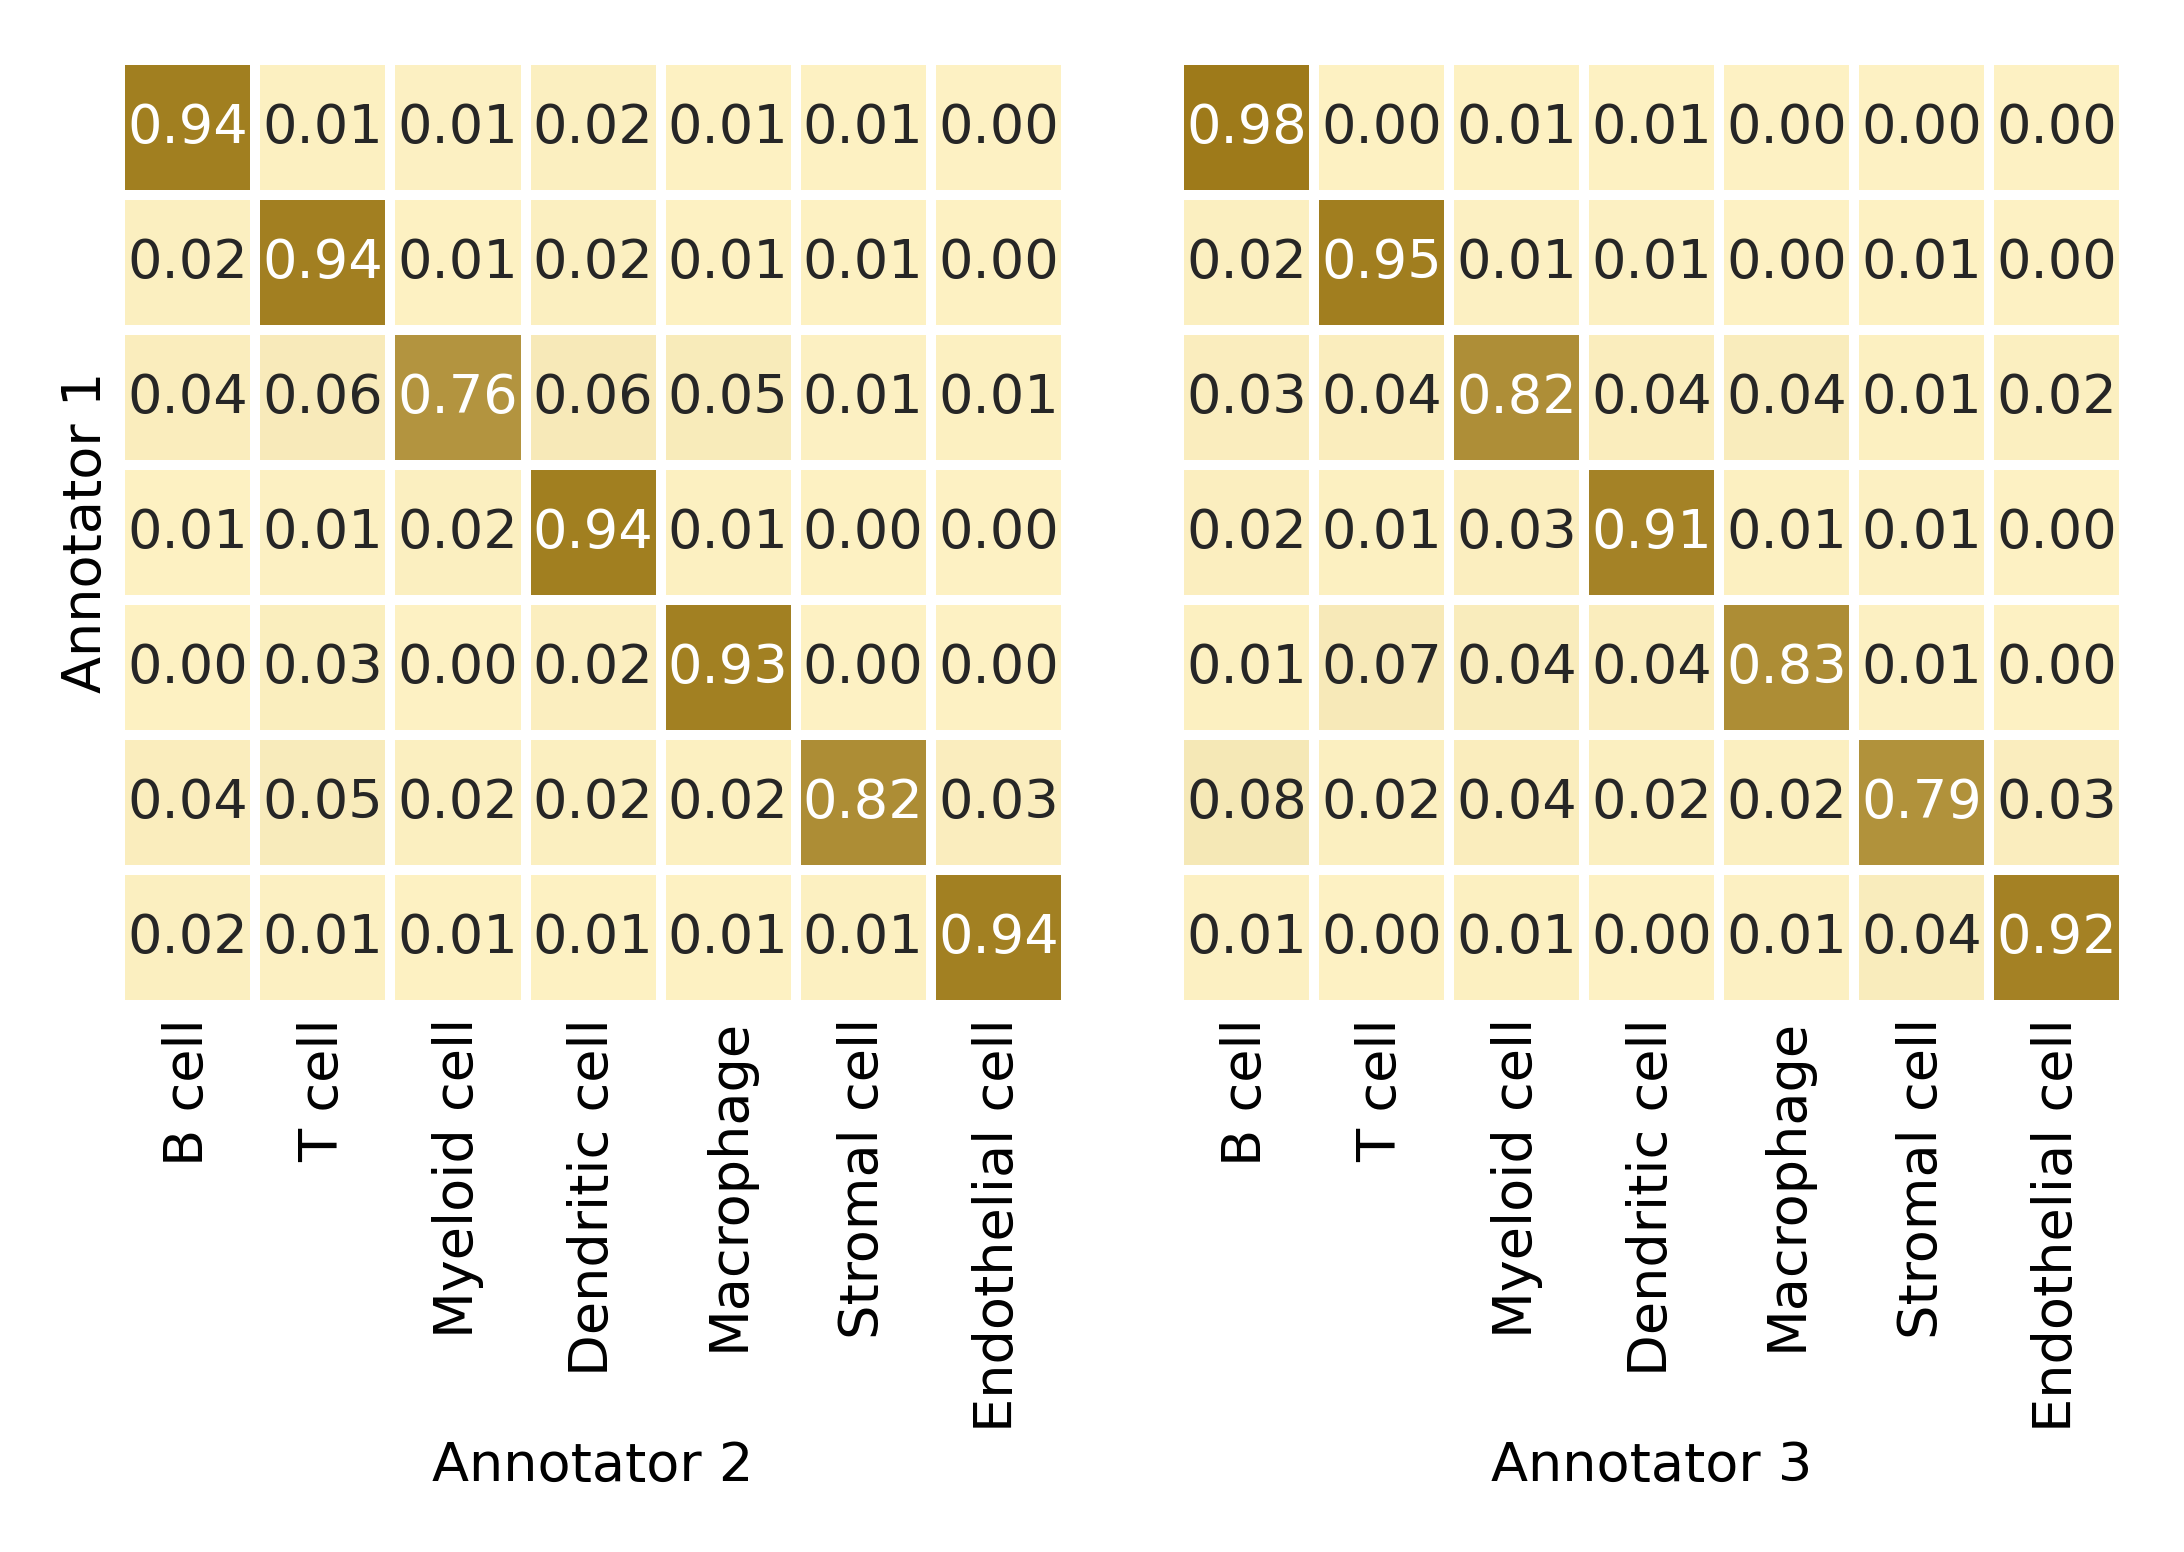

In [8]:
custom_order = list(celltype_colors.keys())
indices = [labels.index(lab) for lab in custom_order]

# Example colormap
bottom_color = "#fdf1c3"
# bottom_color = "white"
top_color = "#9c7817"
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [bottom_color, top_color])
norm = mcolors.Normalize(vmin=0, vmax=1)

cm_nora_reordered = cm_nora[np.ix_(indices, indices)]
cm_nicklas_reordered = cm_nicklas[np.ix_(indices, indices)]

fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), dpi=600, sharey=True)

sns.heatmap(cm_nora_reordered, annot=True, fmt=".2f", cmap=cmap, square=True, 
            linewidths=1, linecolor='white', xticklabels=custom_order, 
            yticklabels=custom_order, cbar=False, norm=norm, ax=axes[0])
axes[0].set_xlabel("Annotator 2")
axes[0].set_ylabel("Annotator 1")

sns.heatmap(cm_nicklas_reordered, annot=True, fmt=".2f", cmap=cmap, square=True, 
            linewidths=1, linecolor='white', xticklabels=custom_order, 
            yticklabels=False, cbar=False, norm=norm, ax=axes[1])
axes[1].set_xlabel("Annotator 3")

axes[0].tick_params(axis='both', length=0)
axes[1].tick_params(axis='both', length=0)

plt.tight_layout()
plt.subplots_adjust(wspace=-0.4)
plt.savefig('figures/thresholding_panel_b.svg', bbox_inches='tight', pad_inches=0, format='svg')
plt.show()

# Expression profiles per ct after thresholding

In [6]:
sample_ids = [x.split("/")[-1].replace(".csv", "") for x in glob('intensity_dfs/matthias/*.csv')]
annotators = ['matthias', 'nora', 'nicklas']
ct_marker_dict = {'PAX5': 'B cell', 'CD3': 'T cell', 'CD11b': 'Myeloid cell',
                  'CD11c': 'Dendritic cell', 'CD68': 'Macrophage',
                  'CD90': 'Stromal cell', 'Podoplanin': 'Stromal cell',
                  'CD31': 'Endothelial cell', 'CD34': 'Endothelial cell'}

markers = list(ct_marker_dict.keys())
cts = ['B cell', 'T cell', 'Myeloid cell', 'Dendritic cell', 'Macrophage', 'Stromal cell', 'Endothelial cell']

annotator_dfs = {}

for annotator in annotators:
    dfs = []
    for sample_id in tqdm(sample_ids):
        df_tmp = pd.read_csv(f'intensity_dfs/{annotator}/{sample_id}.csv', index_col=0)
        dfs.append(df_tmp)
    # combine all samples for this annotator
    annotator_dfs[annotator] = pd.concat(dfs, ignore_index=True)
    
# === 1. Compute averages and global min/max ===
avg_values = []
for annot in annotators:
    df_tmp = annotator_dfs[annot]
    pivot = df_tmp.groupby('label')[markers].mean()
    avg_values.append(pivot)

# Concatenate averages to get global min/max for color scaling
all_avgs = pd.concat(avg_values)
vmin, vmax = all_avgs.min().min(), all_avgs.max().max()

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_10795/3794173977.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


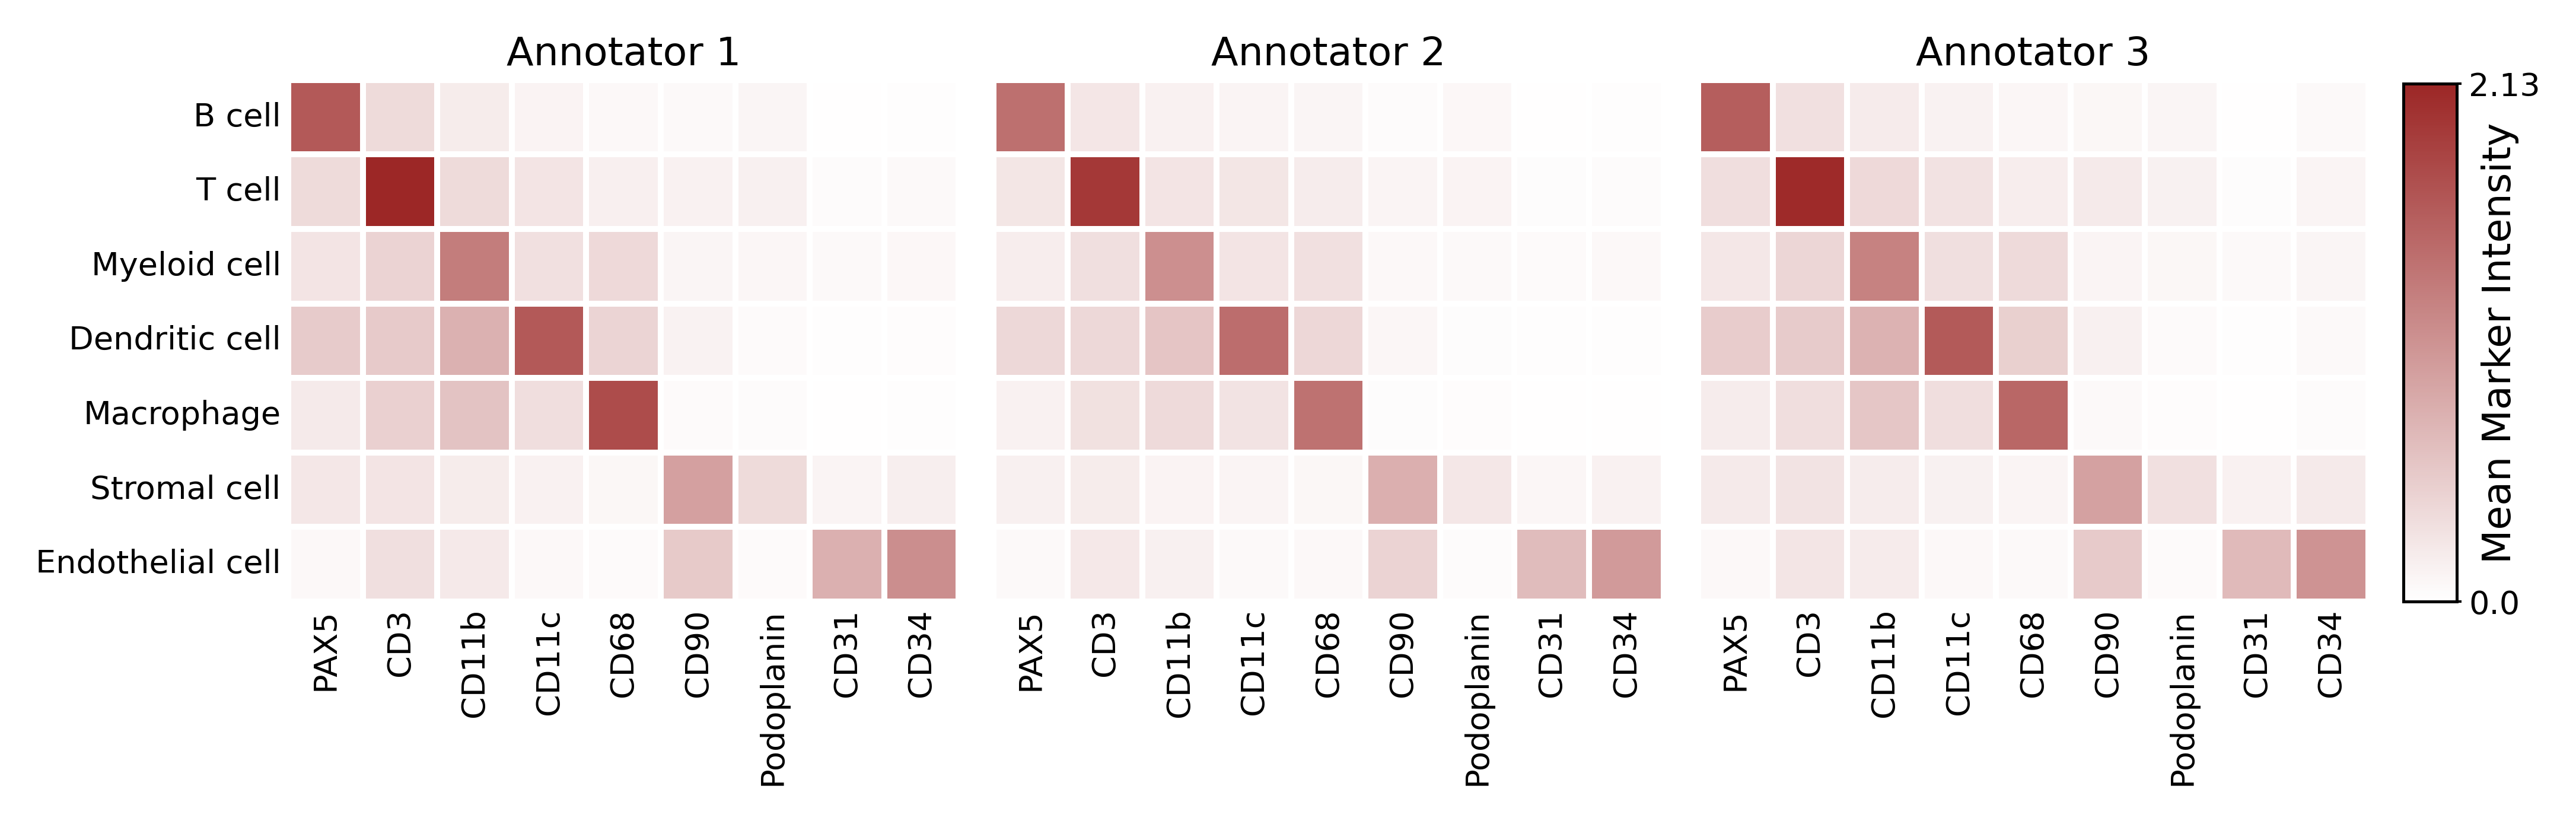

In [13]:
fig, axes = plt.subplots(1, len(annotators), figsize=(7.5, 3), sharey=True, dpi=600)
annotator_mapping = {'matthias': 'Annotator 1', 'nora': 'Annotator 2', 'nicklas': 'Annotator 3'}

# === 2. Define custom colormap ===
bottom_color = "white"  # light
top_color = "#9c2726"     # dark
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [bottom_color, top_color])

# === 3. Plot heatmaps ===
for ax, annot, pivot in zip(axes, annotators, avg_values):
    pivot = pivot.reindex(cts)
    # pivot = pivot[markers]
    
    sns.heatmap(
        pivot,
        cmap=cmap,
        ax=ax,
        cbar=False,   # single colorbar later
        vmin=0,
        vmax=vmax,
        square=True,
        annot=False,
        linewidths=1, linecolor='white',
        fmt=".1f"
    )

    ax.set_title(f"{annotator_mapping[annot]}")
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='both', length=0)

# === 4. Add a single colorbar ===
cbar_ax = fig.add_axes([0.9, 0.26, 0.02, 0.485])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_ticks([0, vmax])
cbar.set_ticklabels([f"{0.}", f"{vmax:.2f}"])
cbar.set_label('Mean Marker Intensity', fontsize=8, labelpad=-12)
cbar.ax.yaxis.set_label_position('right')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.savefig('figures/thresholding_panel_c.svg', bbox_inches='tight', pad_inches=0, format='svg')
plt.show()

# Example Image

Label Dendritic cell not found in the data object. Skipping.
Label Endothelial cell not found in the data object. Skipping.
Label Dendritic cell not found in the data object. Skipping.
Label Macrophage not found in the data object. Skipping.
Label Endothelial cell not found in the data object. Skipping.
Label Dendritic cell not found in the data object. Skipping.
Label Endothelial cell not found in the data object. Skipping.
Label Dendritic cell not found in the data object. Skipping.
Label Endothelial cell not found in the data object. Skipping.


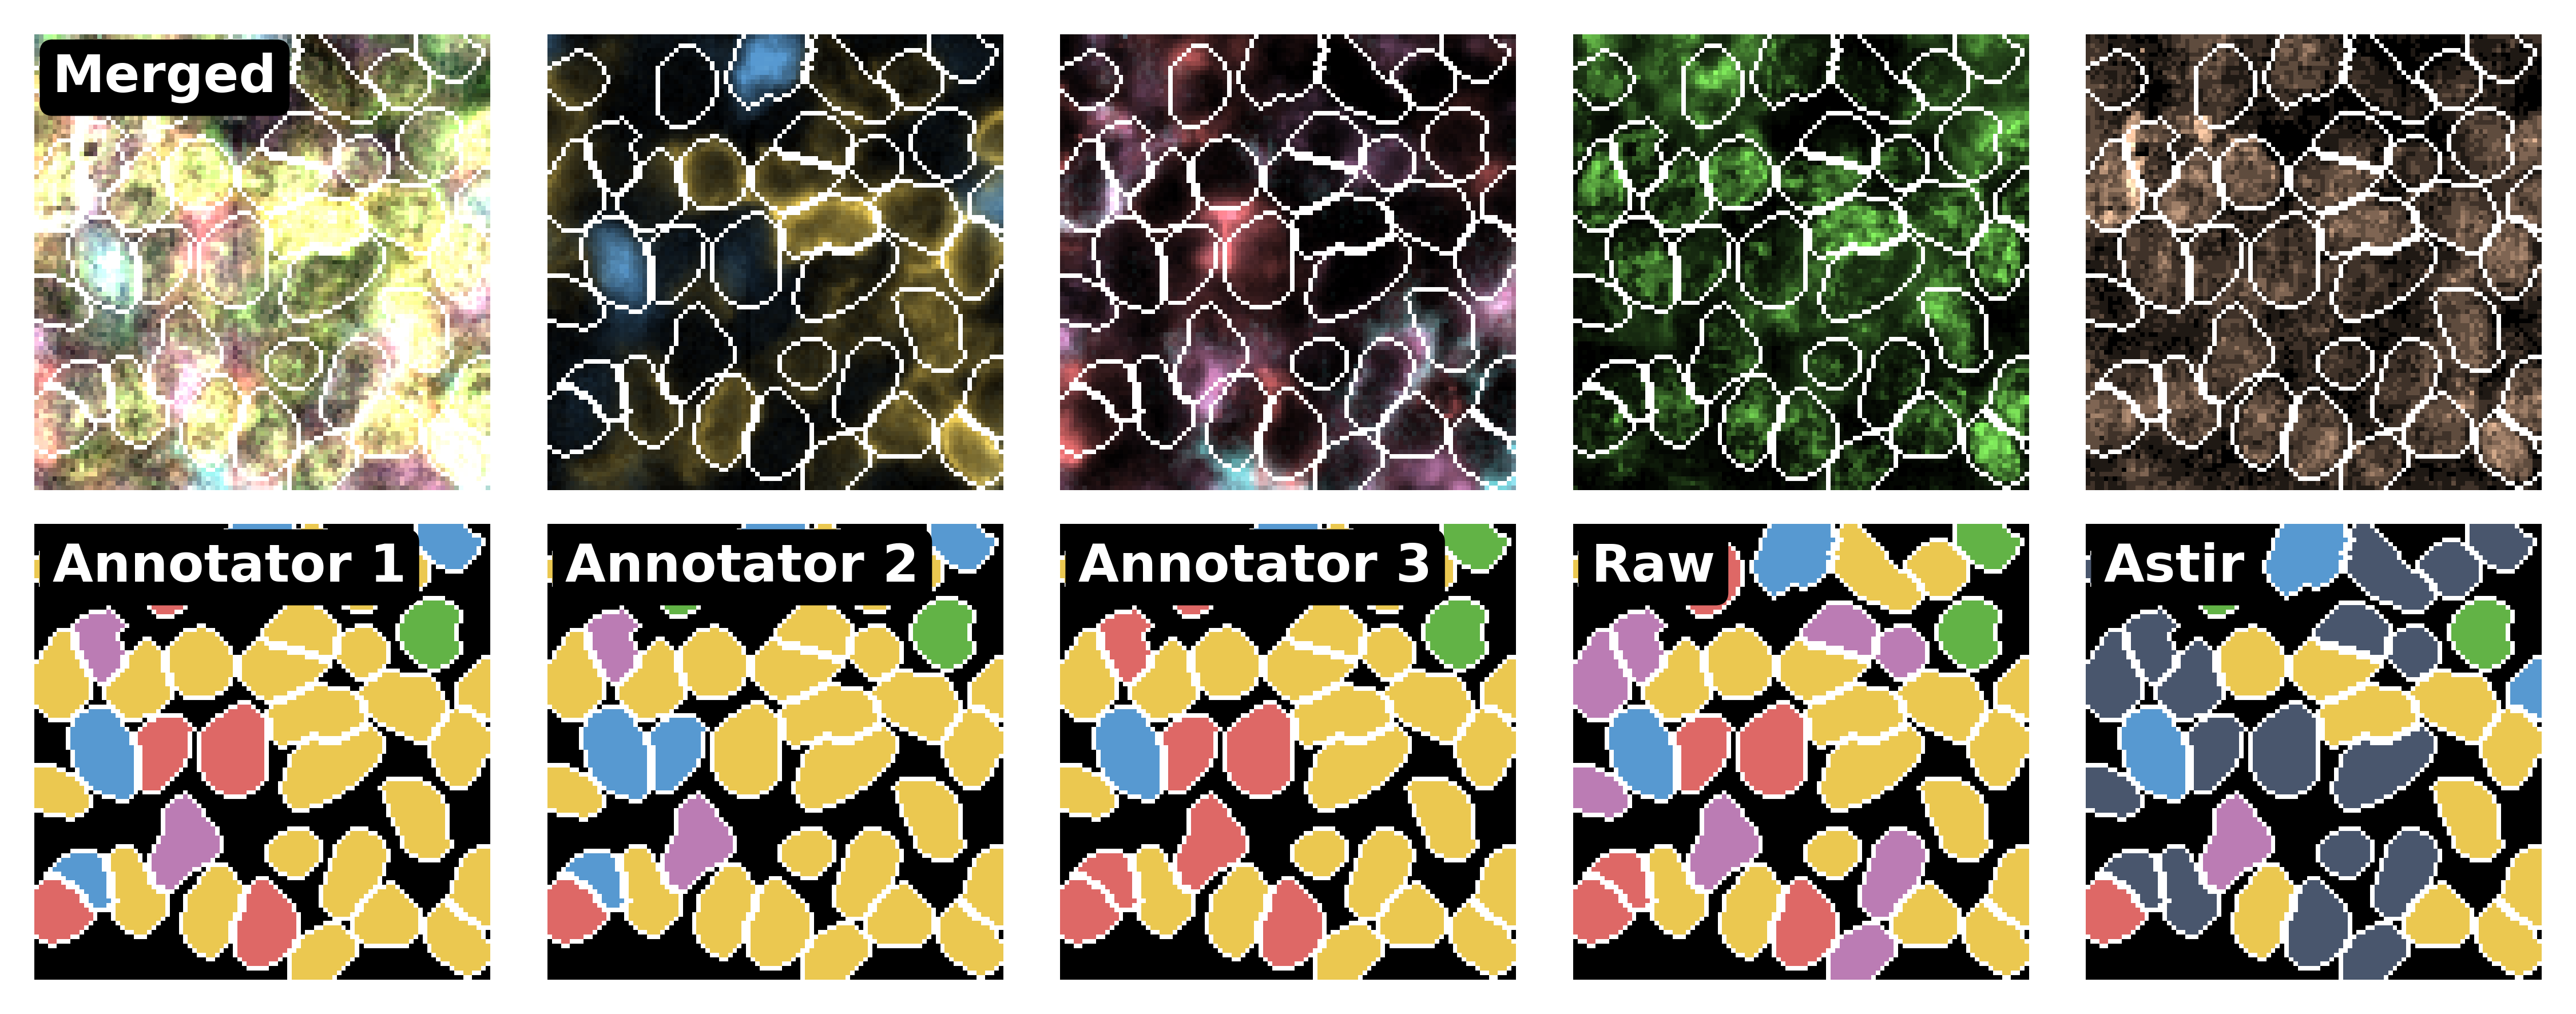

In [8]:
def prepare_dataset(sample_id):
    ds = xr.open_zarr(f"for_nora_and_nicklas/selected_zarrs/{sample_id}.zarr").pp[list(marker_colors.keys())]
    ds = ds.pp.add_layer(ds['_image'].values.copy(), key_added='_raw_image')
    
    df_tmp = df[df['Sample'] == sample_id].iloc[:, :-1].reset_index(drop=True)
    df_tmp2 = df_tmp.copy()
    df_tmp2['cell'] = [x + 1 for x in df_tmp2.index]
    ds = ds.la.add_labels_from_dataframe(df_tmp2, label_col='Matthias').pp.add_layer_from_dataframe(df_tmp)
    
    return ds

def plot_ct_preds(sample_id, xmin, xmax, ymin, ymax):
    ds = prepare_dataset(sample_id)

    fig, ax = plt.subplots(2, 5, figsize=(7.5, 3), dpi=600)
    ax = ax.flatten()
    _ = ds.pp[xmin:xmax, ymin:ymax].pl.colorize(marker_colors.values()).pl.show(legend_image=False, render_segmentation=True, ax=ax[0])
    markers = ['PAX5', 'CD3']
    _ = ds.pp[markers, xmin:xmax, ymin:ymax].pl.colorize([marker_colors[marker] for marker in markers]).pl.show(legend_image=False, render_segmentation=True, ax=ax[1])
    markers = ['CD11b', 'CD11c', 'CD68']
    _ = ds.pp[markers, xmin:xmax, ymin:ymax].pl.colorize([marker_colors[marker] for marker in markers]).pl.show(legend_image=False, render_segmentation=True, ax=ax[2])
    markers = ['CD90', 'Podoplanin']
    _ = ds.pp[markers, xmin:xmax, ymin:ymax].pl.colorize([marker_colors[marker] for marker in markers]).pl.show(legend_image=False, render_segmentation=True, ax=ax[3])
    markers = ['CD31', 'CD34']
    _ = ds.pp[markers, xmin:xmax, ymin:ymax].pl.colorize([marker_colors[marker] for marker in markers]).pl.show(legend_image=False, render_segmentation=True, ax=ax[4])


    _ = ds.pp[xmin:xmax, ymin:ymax].la.set_label_level('Matthias').la.set_label_colors(celltype_colors.keys(), celltype_colors.values()).pl.show(render_segmentation=True, render_image=False, render_labels=True, legend_label=False, ax=ax[5])
    _ = ds.pp[xmin:xmax, ymin:ymax].la.set_label_level('Nora').la.set_label_colors(celltype_colors.keys(), celltype_colors.values()).pl.show(render_segmentation=True, render_image=False, render_labels=True, legend_label=False, ax=ax[6])
    _ = ds.pp[xmin:xmax, ymin:ymax].la.set_label_level('Nicklas').la.set_label_colors(celltype_colors.keys(), celltype_colors.values()).pl.show(render_segmentation=True, render_image=False, render_labels=True, legend_label=False, ax=ax[7])
    _ = ds.pp[xmin:xmax, ymin:ymax].la.set_label_level('Raw').la.set_label_colors(celltype_colors.keys(), celltype_colors.values()).pl.show(render_segmentation=True, render_image=False, render_labels=True, legend_label=False, ax=ax[8])
    _ = ds.pp[xmin:xmax, ymin:ymax].la.set_label_level('Astir').la.set_label_colors(list(celltype_colors.keys()) + ['Other'], list(celltype_colors.values()) + ['#49566d']).pl.show(render_segmentation=True, render_image=False, render_labels=True, legend_label=False, ax=ax[9])

    # Add text in the top-left corner of each subplot
    titles = ['Merged', '', '', '', '', 'Annotator 1', 'Annotator 2', 'Annotator 3', 'Raw', 'Astir']
    for i, title in enumerate(titles):
        if title:  # only add if not empty
            ax[i].text(
                0.04, 0.96, title, 
                fontsize=11, 
                color="white", 
                weight="bold",
                va='top', ha='left',
                transform=ax[i].transAxes,
                bbox=dict(facecolor='black', alpha=1, boxstyle='round,pad=0.2')
            )

    for axis in ax:
        axis.axis('off')
    plt.tight_layout()
    plt.savefig('figures/thresholding_panel_d.svg', bbox_inches='tight', pad_inches=0, format='svg')
    plt.show()
    
sample_id, xmin, xmax, ymin, ymax = 'DLBCL_1_2', 1700, 1800, 1700, 1800
plot_ct_preds(sample_id, xmin, xmax, ymin, ymax)

# Legends

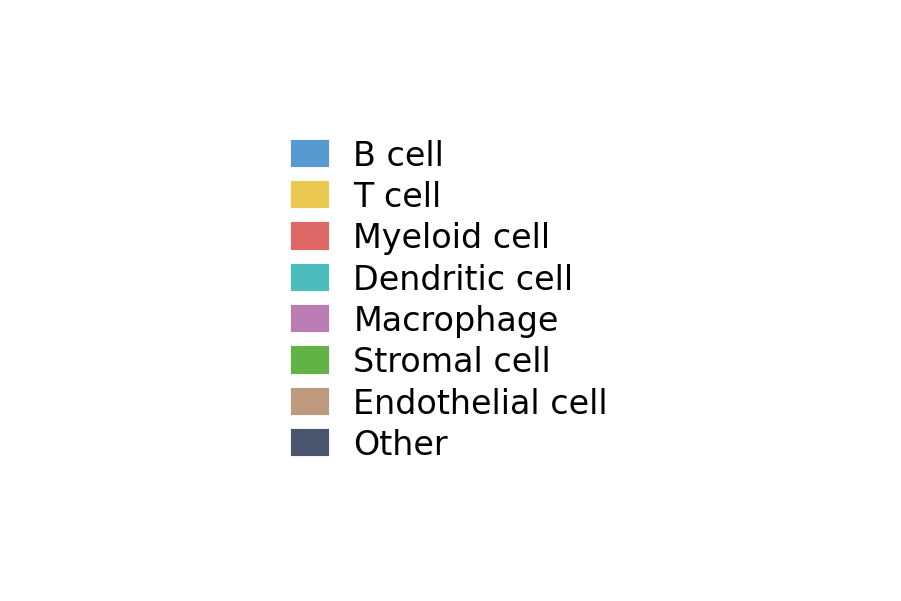

In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

celltype_colors = {
    'B cell': '#5799d1',
    'T cell': '#ebc850',
    'Myeloid cell': '#de6866',
    'Dendritic cell': '#4cbcbd',
    'Macrophage': '#bb7cb4',
    'Stromal cell': '#62b346',
    'Endothelial cell': '#bf997d',
    'Other': '#49566d'
}

# Create proxy artists
handles = [mpatches.Patch(color=color, label=celltype) 
           for celltype, color in celltype_colors.items()]

# Plot just the legend
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
ax.axis("off")  # Hide the axes
legend = ax.legend(handles=handles, 
                   loc="center", 
                   frameon=False, 
                   fontsize=8, 
                   ncol=1)  # change ncol for columns

plt.tight_layout()
plt.savefig('figures/thresholding_panel_d_cell_legend.svg', bbox_inches='tight', pad_inches=0, format='svg')
plt.show()

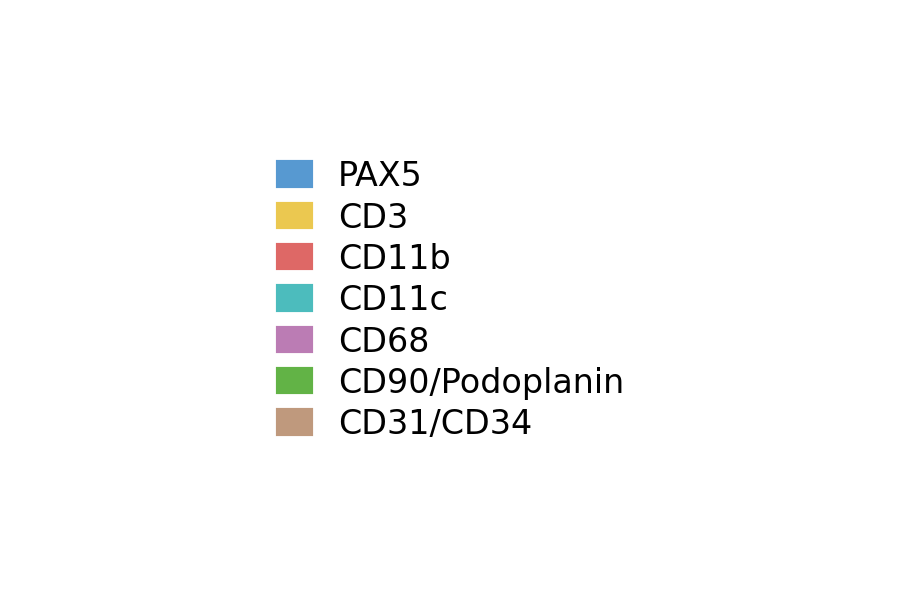

In [10]:
#marker_colors = {
#    'PAX5': '#5799d1',
#    'CD3': '#ebc850',
#    'CD11b': '#de6866',
#    'CD11c': '#4cbcbd',
#    'CD68': '#bb7cb4',
#    'CD90': '#62b346',
#    'Podoplanin': '#62b346',
#    'CD31': '#bf997d',
#    'CD34': '#bf997d',
#}

marker_colors = {
    'PAX5': '#5799d1',
    'CD3': '#ebc850',
    'CD11b': '#de6866',
    'CD11c': '#4cbcbd',
    'CD68': '#bb7cb4',
    'CD90/Podoplanin': '#62b346',
    'CD31/CD34': '#bf997d',
}

# Create proxy artists
handles = [mpatches.Patch(color=color, label=celltype) 
           for celltype, color in marker_colors.items()]

# Plot just the legend
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
ax.axis("off")  # Hide the axes
legend = ax.legend(handles=handles, 
                   loc="center", 
                   frameon=False, 
                   fontsize=8, 
                   ncol=1)  # change ncol for columns

plt.tight_layout()
plt.savefig('figures/thresholding_panel_d_marker_legend.svg', bbox_inches='tight', pad_inches=0, format='svg')
plt.show()

In [11]:
percentage_other = df['Astir'].value_counts(normalize=True).get('Other', 0) * 100
print(f"{percentage_other:.2f}%")

16.70%
